# Denison CS181/DA210 Homework 3.e - Step 1

Before you turn this problem in, make sure everything runs as expected. This is a combination of **restarting the kernel** and then **running all cells** (in the menubar, select Kernel$\rightarrow$Restart And Run All).

Make sure you fill in any place that says `# YOUR CODE HERE` or "YOUR ANSWER HERE".

---

In [1]:
import os
import io
import sys
import importlib
import pandas as pd
from lxml import etree
import requests
from IPython.display import Image

htmlparser =  etree.HTMLParser()

if os.path.isdir(os.path.join("../../..", "modules")):
    module_dir = os.path.join("../../..", "modules")
else:
    module_dir = os.path.join("../..", "modules")

module_path = os.path.abspath(module_dir)
if not module_path in sys.path:
    sys.path.append(module_path)

import util
importlib.reload(util)

<module 'util' from 'C:\\Users\\ngana\\Documents\\SPRING2022\\CS181\\cs181-s22\\modules\\util.py'>

---

## Part A: Topnames Table with GET

Consider the web page at http://datasystems.denison.edu/topnames.html, shown in its rendered form below:

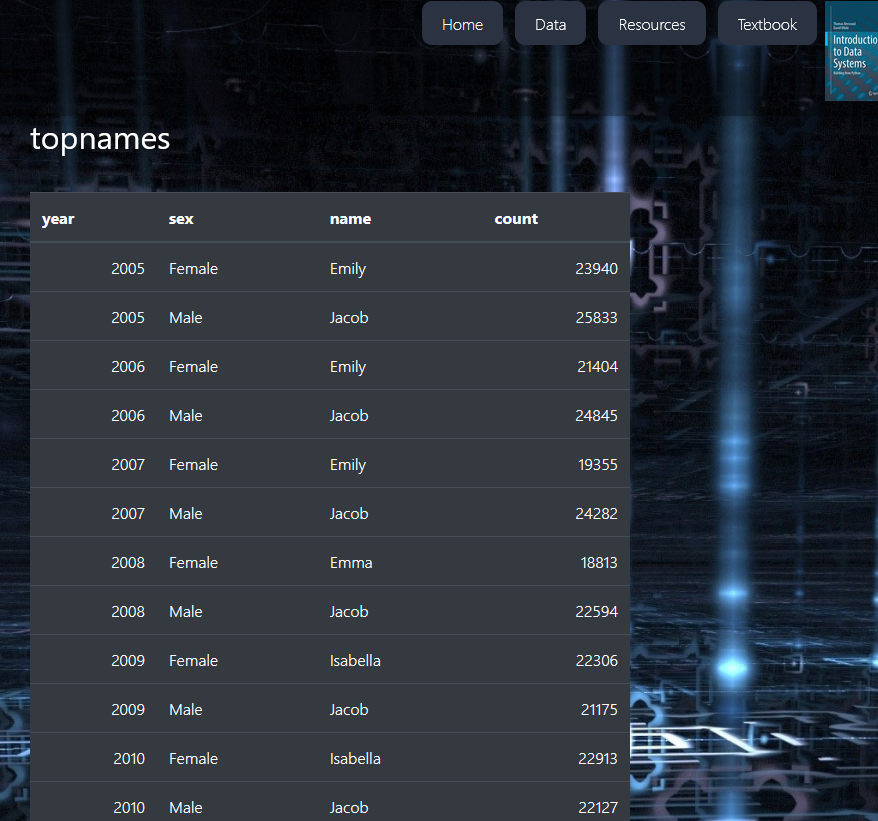

In [2]:
Image("figs/topnames.png", width=600)

#### Discovery

Go to the above web page using Chrome, navigate to View->Developer->Inspect Elements, or in Firefox, Tools->Browser Tools->Web Developer Tools.

You do not have to submit the sketches mentioned below, but the following steps walk you through the discovery process.

1. Find where in the HTML that the "topnames" label for the table exists (not the tab, but in the content of the page proper).
2. Traverse "up" to the first `div` ancestor, and sketch the HTML subtree starting at that point, down to and including the label text, but only covering the first full subtree of the `div` (containing the label).
3. Find the `table` node within the overall tree, and then draw the subtee rooted at `table`.  You need only include the first two data-carrying rows of data.  You can also use abbreviations of your own choosing to make this less onerous.

#### Code Setup

In [33]:
# DO NOT CHANGE THIS

# Read HTML from the web
url = util.buildURL("/topnames.html", "datasystems.denison.edu")
response = requests.get(url)
assert response.status_code == 200

# Use a custom HTML parser to parse the response content into an XML Element
tree = etree.parse(io.BytesIO(response.content), htmlparser)
root = tree.getroot()

**Q1:** Create in `xs_q1` an XPath expression that (uniquely) finds the `div` that is the common ancestor of both the topnames label and the `table` containing the data.  Assign the node itself (not the list containing the node) to the variable `divroot`.

In [35]:
xs_q1 = "//div"
divroot = root.xpath(xs_q1)[5]

# Display the first 20 lines of the tree
util.print_xml(divroot, depth=16, nlines=20)

<div id='non-nav' style='margin-top: 120px; padding-left: 6
  <div id='main-content'>
    <h2 class='title'>
      <span ...>topnames</span>
    </h2>
    <div class='article' style='padding-top: 30px'>
      <div class='article-content'>
        <div class='RichTextElement'>
          <div>
            <div class='first wide center'>
              <div style='' class='graphic'>
                <div class=''>
                  <span ...>
                    <table class='table table-dark' style='
                      <thead>
                        <tr>
                          <th title='Field #1'>year</th>
                          <th title='Field #2'>sex</th>
                          <th title='Field #3'>name</th>
                          <th title='Field #4'>count</th>


In [36]:
# Testing cell
assert type(xs_q1) is str
assert len(root.xpath(xs_q1)) == 1
assert type(divroot) is etree._Element
assert divroot.tag == "div"
assert len(divroot) == 3 # includes a comment: <!--...-->

AssertionError: 

**Q2:**  Either using the `root` of the HTML tree, or from the `divroot` found above, assign to `xs_q2` an XPath expression to get a list of the tables in the HTML, then execute the XPath and assign to the Python variable `table` the first such table.

In [37]:
xs_q2 = "//table"
table = divroot.xpath(xs_q2)[0]

# Display the first 30 lines of the tree
util.print_xml(table, depth=16, nlines=30)

<table class='table table-dark' style='width: 600px'>
  <thead>
    <tr>
      <th title='Field #1'>year</th>
      <th title='Field #2'>sex</th>
      <th title='Field #3'>name</th>
      <th title='Field #4'>count</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td align='right'>2005</td>
      <td>Female</td>
      <td>Emily</td>
      <td align='right'>23940</td>
    </tr>
    <tr>
      <td align='right'>2005</td>
      <td>Male</td>
      <td>Jacob</td>
      <td align='right'>25833</td>
    </tr>
    <tr>
      <td align='right'>2006</td>
      <td>Female</td>
      <td>Emily</td>
      <td align='right'>21404</td>
    </tr>
    <tr>
      <td align='right'>2006</td>


In [38]:
# Testing cell
assert type(xs_q2) is str
assert type(table) is etree._Element
assert table.tag == "table"
assert len(table) == 2
assert table[0].tag == "thead"
assert table[1][0][0].text == "2005"

**Q3:** Use the result of `print_xml` to make sure your understanding of the `table` tree matches your hand-drawn tree from earlier.  If you chose to start from `root`, would your expression be **guaranteed** to get the table you are interested in?  Why or why not?

YOUR ANSWER HERE

#### Programmatic Extraction: List of Lists

**Q4:** Assign to `xs_q4` an XPath expression that retrieves the names of the columns of the table, and use that expression to assign that list to `col_names`.  Write your expression as an absolute one, working from the `root` (therefore, _not_ a relative expression from a given non-root node).

In [39]:
xs_q4 = "//th/text()"
col_names = table.xpath(xs_q4)

# Print the list of column names
print(col_names)

['year', 'sex', 'name', 'count']


In [41]:
# Testing cell
assert type(xs_q4) is str
assert len(root.xpath(xs_q4)) == 4
assert type(col_names) is list
assert len(col_names) == 4
assert "year" in col_names
assert "count" in col_names

Note that if the HTML document had multiple tables, then the XPath expression above would match header cells from all `th` elements anywhere in the document, including ones in totally separate tables.  In such a case, we may have to make further assumptions about the structure of the HTML to uniquely find the desired table.  

In the following, we will assume that the variable `table` refers to the correct table, and focus on extracting the data and transforming it into a data frame.

A method from the textbook solves this problem by the following steps:

1. Use XPath to retrieve a single list of the text property of all `td` nodes under the `tbody`.
2. Using the knowledge that there are four fields per row, iterate over this single list and, by putting sequential sets of four elements into a row list, create a LoL representation of the data.
3. Build the dataframe based on the LoL and the column names.

In the following cells, we ask you to reproduce that method.  Use your textbook if you  need  help.

**Q5:** In the following cell, use XPath on  `table` to obtain a single list of the text of all the `td`-tagged nodes.  Assign the result to `tdlist`.

In [42]:
tdlist = table.xpath("//td/text()")

print(len(tdlist))
print("td list prefix:", tdlist[0:10])

112
td list prefix: ['2005', 'Female', 'Emily', '23940', '2005', 'Male', 'Jacob', '25833', '2006', 'Female']


In [43]:
# Testing cell
assert type(tdlist) is list
assert len(tdlist) == 112
assert tdlist[0] == "2005"
assert tdlist[7] == "25833"

**Q6:** Process the `td` text in `tdlist` into an LoL, stored in a variable `LoL`.  Here are the steps used in the book:

* Create an  empty  list, `LoL`, and a counter variable.
* Write a `for`-loop that iterates over `tdlist`.
  - If the counter is zero, create a new empty row list.
  - Add the current `td` item to the list.
  - Increment the counter if there are more fields to be accumulated into the row list, or reset the counter to zero if a row is complete.
  - When a row is complete, the row should be appended to `LoL`.

Upon completion, `LoL` should be a list of row lists with string versions of the data for each row.

In [46]:
LoL = []
counter = 0
for data in tdlist:
    if counter == 0:
        row = []
    row.append(data)
    if counter < 3:
        counter += 1
    else:
        LoL.append(row)
        counter = 0

# Display the first ten rows of data
LoL[:10]

[['2005', 'Female', 'Emily', '23940'],
 ['2005', 'Male', 'Jacob', '25833'],
 ['2006', 'Female', 'Emily', '21404'],
 ['2006', 'Male', 'Jacob', '24845'],
 ['2007', 'Female', 'Emily', '19355'],
 ['2007', 'Male', 'Jacob', '24282'],
 ['2008', 'Female', 'Emma', '18813'],
 ['2008', 'Male', 'Jacob', '22594'],
 ['2009', 'Female', 'Isabella', '22306'],
 ['2009', 'Male', 'Jacob', '21175']]

In [47]:
# Testing cell
assert type(LoL) is list
assert len(LoL) == 28
assert len(LoL[0]) == 4
assert LoL[0][-1] == "23940"
assert LoL[-1][2] == "Liam"

**Q7:** Finally, use our standard techniques for turning the LoL into a `pandas` data frame, setting the index to the combination of year and sex, and assigning the result to variable `df`.

In [59]:
df = pd.DataFrame(LoL, columns = col_names)
df.set_index(['year', 'sex'], inplace = True)

# Display the first ten rows of the DataFrame
df.head(10)

name  count
year sex                    
2005 Female     Emily  23940
     Male       Jacob  25833
2006 Female     Emily  21404
     Male       Jacob  24845
2007 Female     Emily  19355
     Male       Jacob  24282
2008 Female      Emma  18813
     Male       Jacob  22594
2009 Female  Isabella  22306
     Male       Jacob  21175

In [60]:
# Testing cell
assert type(df) is pd.DataFrame
assert df.shape == (28,2)
assert df.loc[("2007", 'Male'), 'count'] == "24282"
assert df.loc[("2016", 'Male'), 'name'] == "Noah"

#### Programmatic Extraction: Dictionary of Column Lists

A perhaps simpler solution involves using the regularity of the columns in a table (be it in HTML or other regular table form).  Within each `tr`, the **position** of each of the `td` elements for the four fields in this table is always the same, regardless of row.  So at position 1 within all the rows, we always have the year, at position 2, we always have the sex, and so forth.

**Q8:** Assign to `xs_q8` an XPath expression that retrieves, relative to `table`, the text property for all `td` elements under a `tr` where the `td` is the position 1 child of the `tr`.  Execute the xpath on `table` and assign the result to variable `year_vector`.

In [62]:
xs_q8 = "//td[1]/text()"
year_vector = table.xpath(xs_q8)

# Print info about the year vector
print(len(year_vector))
print("year vector prefix:", year_vector[:10])

28
year vector prefix: ['2005', '2005', '2006', '2006', '2007', '2007', '2008', '2008', '2009', '2009']


In [63]:
# Testing cell
assert type(xs_q8) is str
assert len(root.xpath(xs_q8)) == 28
assert type(year_vector) is list
assert len(year_vector) == 28
assert year_vector[0] == "2005"
assert year_vector[-1] == "2018"

**Q9:** We could do this four times, with different values for the position, creating four vectors and then constructing the dictionary.  Instead, we want to use Python string formatting to dynamically create an xpath query that retrieves the `td` at a position given by a variable, and then traverses to the text attribute.

Assign to `xs_template_q9` a Python string using `{}` in place of the position from your solution above, so that the testing code shows its use by obtaining the four data columns from the table.

In [66]:
xs_template_q9 = "//td[{}]/text()"

# Test your template, retrieving two of the four column vectors
years = table.xpath(xs_template_q9.format(1))
print(years[:8])
counts = table.xpath(xs_template_q9.format(4))
print(counts[:8])

['2005', '2005', '2006', '2006', '2007', '2007', '2008', '2008']
['23940', '25833', '21404', '24845', '19355', '24282', '18813', '22594']


In [67]:
# Testing cell
assert type(xs_template_q9) is str
assert "'pineapple'" in xs_template_q9.format("pineapple")
assert len(years) == 28
assert len(counts) == 28
assert years[2] == "2006"
assert counts[-1] == "19837"

AssertionError: 

**Q10:** We can build a DoL using a `for` loop that, at each iteration, allows us to define a `position` and a `columnname`.  The position should be used to format an appropriate xpath query to get the set of column values at that position (like we did without a loop in the last question).

Build the DoL, in a variable `DoL`, using the above approach.  The dictionary keys should be column names, and the value lists should be built using your xpath template string.

In [68]:
DoL = {}
for index, column in enumerate(col_names):
    DoL[column] = table.xpath(xs_template_q9.format(index + 1))

# Print the first ten rows of the resulting DoL
print(list(DoL.keys()))
for rowid in range(10):
    print([DoL[col][rowid] for col in DoL])

['year', 'sex', 'name', 'count']
['2005', 'Female', 'Emily', '23940']
['2005', 'Male', 'Jacob', '25833']
['2006', 'Female', 'Emily', '21404']
['2006', 'Male', 'Jacob', '24845']
['2007', 'Female', 'Emily', '19355']
['2007', 'Male', 'Jacob', '24282']
['2008', 'Female', 'Emma', '18813']
['2008', 'Male', 'Jacob', '22594']
['2009', 'Female', 'Isabella', '22306']
['2009', 'Male', 'Jacob', '21175']


In [69]:
# Testing cell
assert type(DoL) is dict
assert type(DoL["name"]) is list
assert len(DoL["count"]) == 28
assert DoL["year"][0] == "2005"
assert DoL["name"][-1] == "Liam"
assert DoL["count"][7] == "22594"

---

---

## Part B

**Q11:** How much time (in minutes/hours) did you spend on this homework assignment?

1.5h

**Q12:** Who was your partner for this assignment?  If you worked alone, say so instead.

I worked alone